Loading Libraries

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split ,GridSearchCV
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

Loading Dataset

In [27]:
df=pd.read_csv("martenal.csv")
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


In [28]:
df.info

<bound method DataFrame.info of       Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0      25         130           80  15.0      98.0         86  high risk
1      35         140           90  13.0      98.0         70  high risk
2      29          90           70   8.0     100.0         80  high risk
3      30         140           85   7.0      98.0         70  high risk
4      35         120           60   6.1      98.0         76   low risk
...   ...         ...          ...   ...       ...        ...        ...
1009   22         120           60  15.0      98.0         80  high risk
1010   55         120           90  18.0      98.0         60  high risk
1011   35          85           60  19.0      98.0         86  high risk
1012   43         120           90  18.0      98.0         70  high risk
1013   32         120           65   6.0     101.0         76   mid risk

[1014 rows x 7 columns]>

Data Cleaning

In [29]:
missing_values = df.isnull().sum()
print(missing_values)

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


Summary Statistics

In [30]:
#numerical variables
summary_stats = df.describe()
print(summary_stats.head())

               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913    13.885796     3.293532     1.371384   
min      10.000000    70.000000    49.000000     6.000000    98.000000   
25%      19.000000   100.000000    65.000000     6.900000    98.000000   

         HeartRate  
count  1014.000000  
mean     74.301775  
std       8.088702  
min       7.000000  
25%      70.000000  


In [31]:
#categorical variables
risk_level_counts = df['RiskLevel'].value_counts()
print(risk_level_counts)

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


EXPLORATORY DATA ANALYSIS

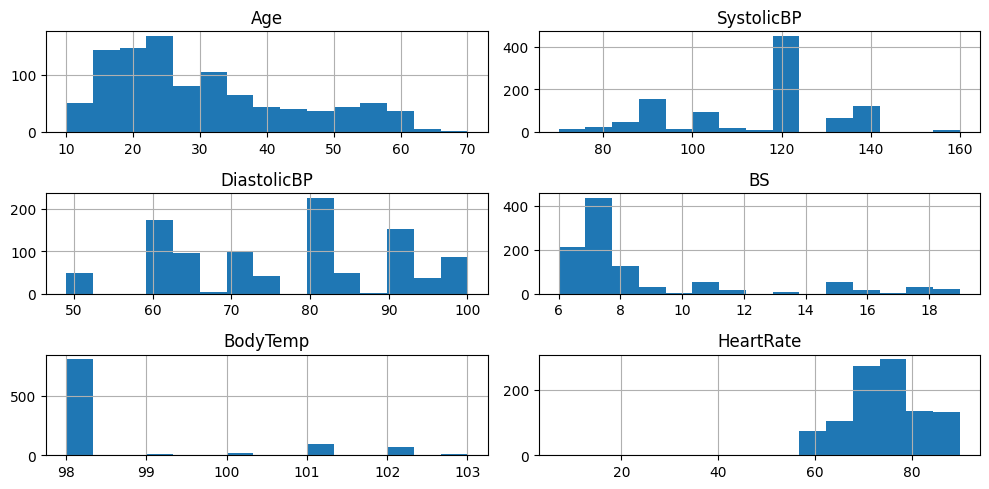

In [32]:
numerical_vars = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df[numerical_vars].hist(bins=15, figsize=(10, 5))
plt.tight_layout()
plt.show()

C:\Users\charity\AppData\Local\Temp\ipykernel_18288\622131572.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_risk_counts = df.groupby(['age_bin', 'RiskLevel']).size().unstack().fillna(0)


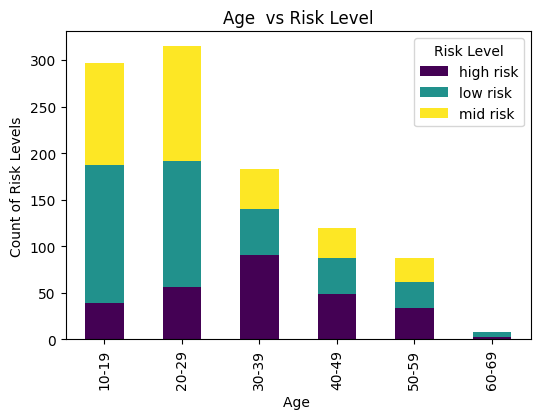

In [33]:
age_bins = [10,20, 30, 40, 50, 60, 70]
age_labels = ['10-19','20-29', '30-39', '40-49', '50-59', '60-69']

df['age_bin'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels)
age_risk_counts = df.groupby(['age_bin', 'RiskLevel']).size().unstack().fillna(0)

age_risk_counts.plot(kind='bar', stacked=True, figsize=(6, 4), colormap='viridis')
plt.title('Age  vs Risk Level')
plt.xlabel('Age ')
plt.ylabel('Count of Risk Levels')
plt.legend(title='Risk Level')
plt.show()





In [34]:
df = df.drop(columns=['age_bin'])
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


Outlier Detection

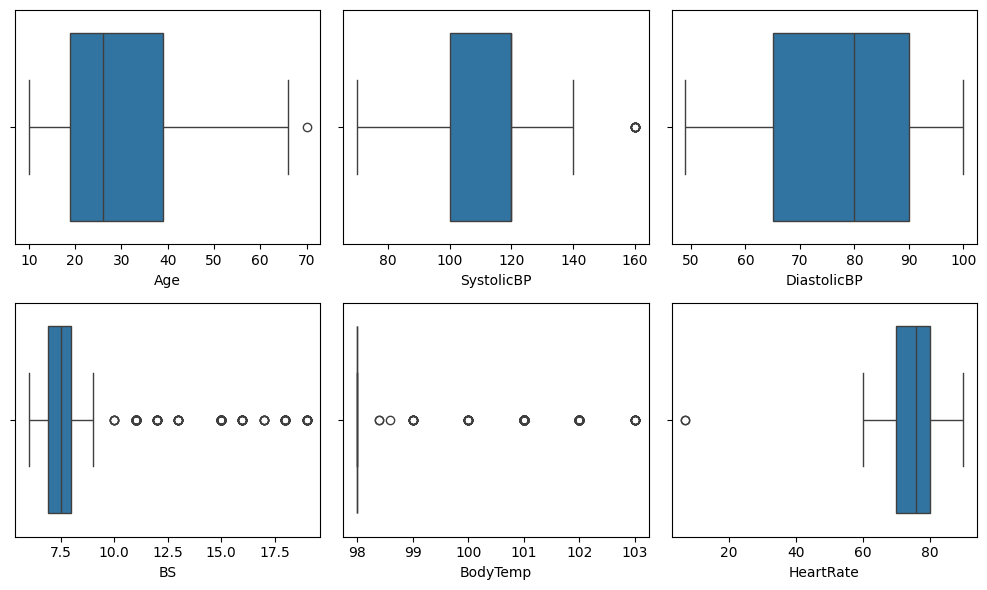

In [35]:
plt.figure(figsize=(10, 6))
for i, var in enumerate(numerical_vars):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=df[var])
plt.tight_layout()
plt.show()

Handling outliers

In [36]:
def calculate_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return Q1, Q3, IQR


In [37]:
Q1_age, Q3_age, IQR_age = calculate_iqr(df, 'Age')
Q1_bs, Q3_bs, IQR_bs = calculate_iqr(df, 'BS')
Q1_body_temp, Q3_body_temp, IQR_body_temp = calculate_iqr(df, 'BodyTemp')
Q1_heart_rate, Q3_heart_rate, IQR_heart_rate = calculate_iqr(df, 'HeartRate')

In [38]:
#Removing outliers
df = df[
    ~((df['Age'] < (Q1_age - 1.5 * IQR_age)) | 
      (df['Age'] > (Q3_age + 1.5 * IQR_age)) |
      (df['BS'] < (Q1_bs - 1.5 * IQR_bs)) |
      (df['BS'] > (Q3_bs + 1.5 * IQR_bs)) |
      (df['HeartRate'] < (Q1_heart_rate - 1.5 * IQR_heart_rate)) |
      (df['HeartRate'] > (Q3_heart_rate + 1.5 * IQR_heart_rate)))
]

Data Transformations

In [39]:
df['BS'] = np.log1p(df['BS'])  
df['BodyTemp'] = np.log1p(df['BodyTemp'])

# Apply standardization
scaler = StandardScaler()
df_transformed = pd.DataFrame(scaler.fit_transform(df[numerical_vars]), columns=numerical_vars)

C:\Users\charity\AppData\Local\Temp\ipykernel_18288\229532063.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BS'] = np.log1p(df['BS'])
C:\Users\charity\AppData\Local\Temp\ipykernel_18288\229532063.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['BodyTemp'] = np.log1p(df['BodyTemp'])


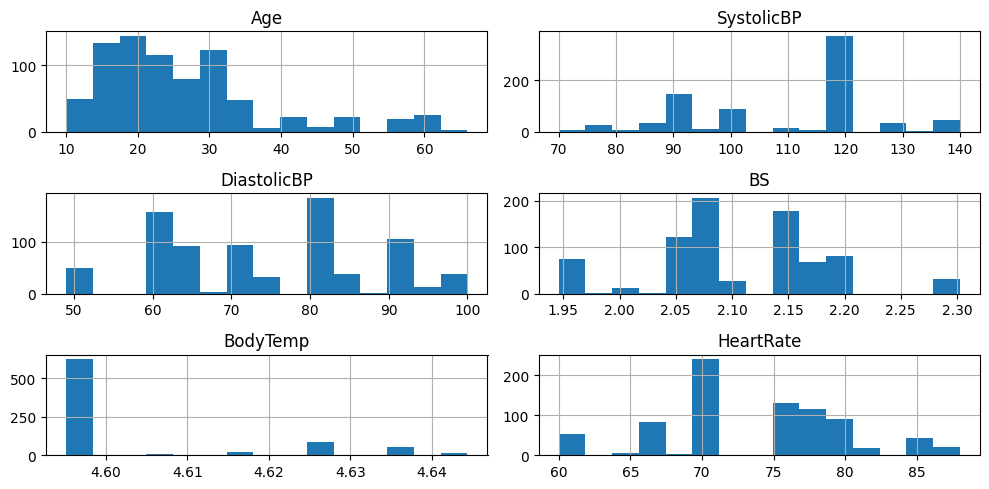

In [40]:
numerical_vars = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
df[numerical_vars].hist(bins=15, figsize=(10, 5))
plt.tight_layout()
plt.show()

Correlation Matrix

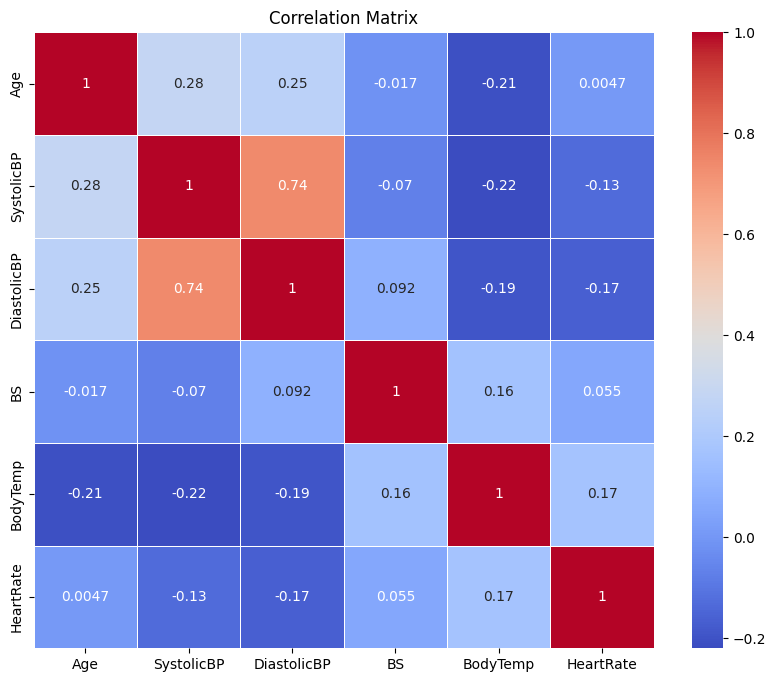

In [41]:
correlation_matrix = df[numerical_vars].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

Pairplot

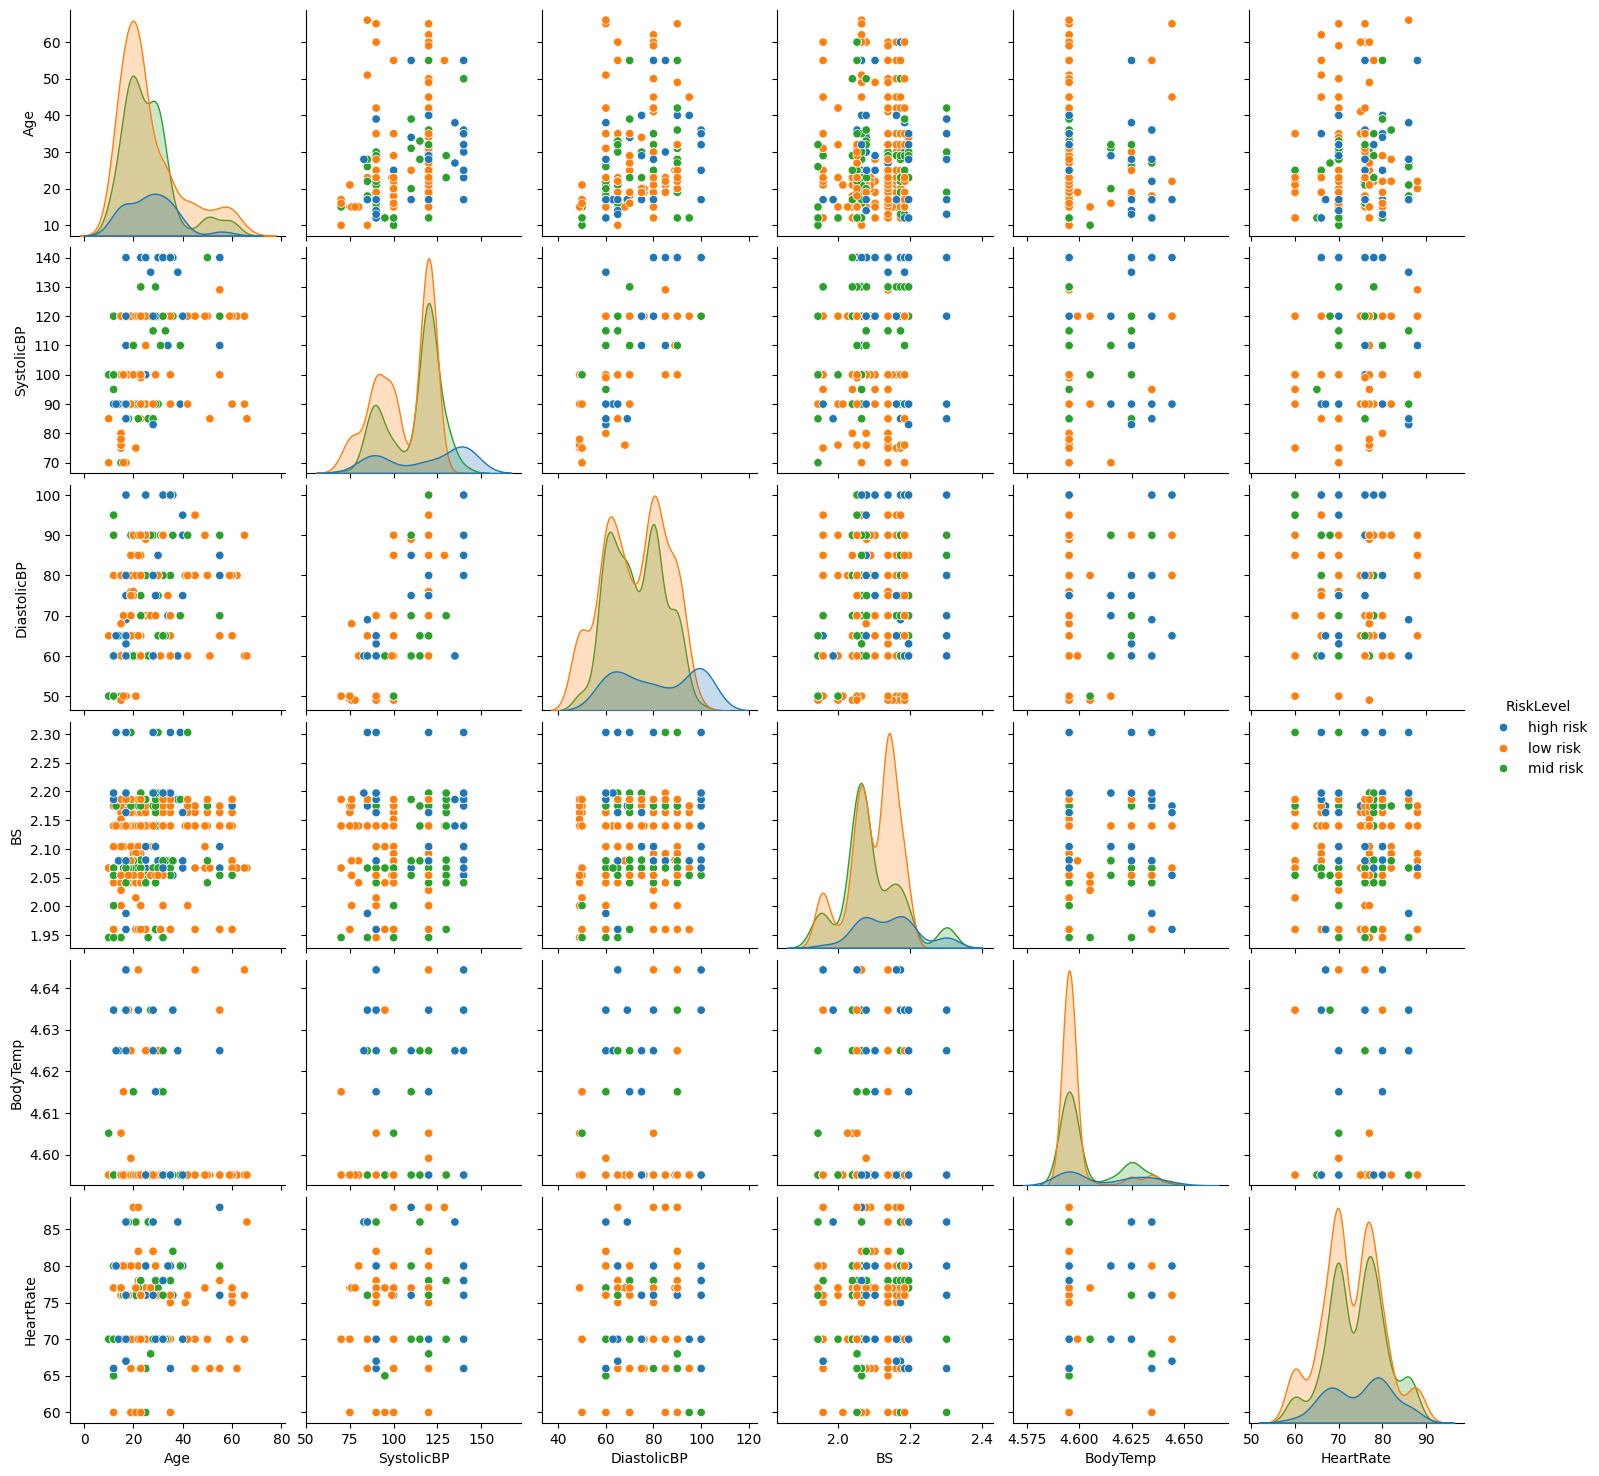

In [42]:
sns.pairplot(df, hue='RiskLevel')
plt.show()

Feature Selection

In [43]:
x = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

Encoding Categorical variables

In [44]:
from sklearn.preprocessing import LabelEncoder

y = df['RiskLevel'].values.ravel()

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


Splitting data

In [45]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Training set size: {x_train.shape[0]}")
print(f"Testing set size: {x_test.shape[0]}")

Training set size: 640
Testing set size: 161


Standardizing data

Creating pipelines for models

In [46]:
pipelines = {
    'decision_tree': Pipeline([
        ('clf', DecisionTreeClassifier(random_state=42))
    ]),
    'random_forest': Pipeline([
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'svm': Pipeline([
        ('scaler', StandardScaler()),  # SVM benefits from feature scaling
        ('clf', SVC(random_state=42))
    ])
}

Setting hyperparameters for grid search

In [47]:
param_grids = {
    'decision_tree': {
        'clf__max_depth': [3, 5, 7, 10],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'random_forest': {
        'clf__n_estimators': [50, 100, 200],
        'clf__max_depth': [None, 10, 20],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    },
    'svm': {
        'clf__C': [0.1, 1, 10],
        'clf__gamma': [1, 0.1, 0.01],
        'clf__kernel': ['linear', 'rbf']
    }
}

Perform Grid Search and Train Models

In [48]:
best_models = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, n_jobs=-1, scoring='accuracy')
    grid_search.fit(x_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

Best parameters for decision_tree: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
Best parameters for random_forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best parameters for svm: {'clf__C': 10, 'clf__gamma': 1, 'clf__kernel': 'rbf'}


Evaluation and Model Comparison


Evaluating decision_tree...
Classification Report for decision_tree:
              precision    recall  f1-score   support

   high risk       0.94      0.84      0.89        19
    low risk       0.70      0.68      0.69        79
    mid risk       0.64      0.68      0.66        63

    accuracy                           0.70       161
   macro avg       0.76      0.74      0.75       161
weighted avg       0.71      0.70      0.70       161

Confusion Matrix for decision_tree:
[[16  3  0]
 [ 1 54 24]
 [ 0 20 43]]


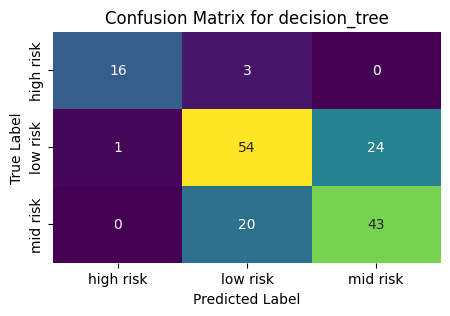

Training Accuracy for decision_tree: 0.8703
Testing Accuracy for decision_tree: 0.7019

Evaluating random_forest...
Classification Report for random_forest:
              precision    recall  f1-score   support

   high risk       0.84      0.84      0.84        19
    low risk       0.79      0.80      0.79        79
    mid risk       0.79      0.78      0.78        63

    accuracy                           0.80       161
   macro avg       0.81      0.81      0.81       161
weighted avg       0.80      0.80      0.80       161

Confusion Matrix for random_forest:
[[16  3  0]
 [ 3 63 13]
 [ 0 14 49]]


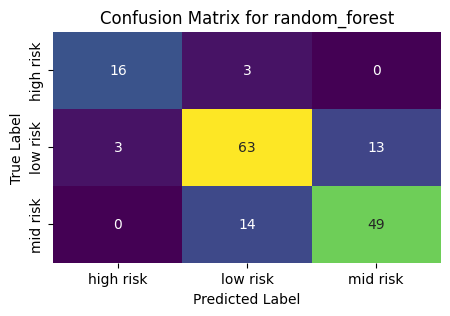

Training Accuracy for random_forest: 0.9375
Testing Accuracy for random_forest: 0.7950

Evaluating svm...
Classification Report for svm:
              precision    recall  f1-score   support

   high risk       0.84      0.84      0.84        19
    low risk       0.75      0.72      0.74        79
    mid risk       0.71      0.75      0.73        63

    accuracy                           0.75       161
   macro avg       0.77      0.77      0.77       161
weighted avg       0.75      0.75      0.75       161

Confusion Matrix for svm:
[[16  3  0]
 [ 3 57 19]
 [ 0 16 47]]


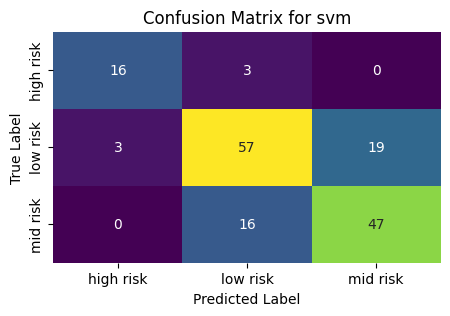

Training Accuracy for svm: 0.9047
Testing Accuracy for svm: 0.7453


In [49]:
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(x_test)
    
    # Print classification report and confusion matrix
    print(f"Classification Report for {model_name}:\n{classification_report(y_test, y_pred)}")
    print(f"Confusion Matrix for {model_name}:\n{confusion_matrix(y_test, y_pred)}")
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print accuracy
    train_accuracy = model.score(x_train, y_train)
    test_accuracy = model.score(x_test, y_test)
    print(f"Training Accuracy for {model_name}: {train_accuracy:.4f}")
    print(f"Testing Accuracy for {model_name}: {test_accuracy:.4f}")

Decision tree Classifier

Model Interpretation

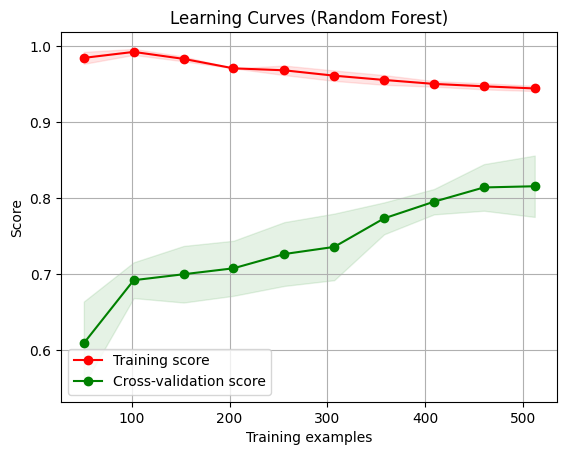

In [50]:
from sklearn.model_selection import learning_curve
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Calculating learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model, x_train, y_train, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy', n_jobs=-1
)

# Calculating mean and std deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting learning curves
plt.figure()
plt.title('Learning Curves (Random Forest)')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.grid()

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')

plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()